In [ ]:
!pip install -q transformers datasets textattack imbalanced-learn ftfy unidecode emoji

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import pandas as pd

splits = {'train': 'split/train-00000-of-00001.parquet', 'validation': 'split/validation-00000-of-00001.parquet', 'test': 'split/test-00000-of-00001.parquet'}
df_train = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["train"])

In [ ]:
df_test = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["test"])

In [ ]:
df_validation = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["validation"])

In [ ]:
print(df_train.head())
print(df_test.head())
print(df_validation.head())

                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3
                                                text  label
0  im feeling rather rotten so im not very ambiti...      0
1          im updating my blog because i feel shitty      0
2  i never make her separate from me because i do...      0
3  i left with my bouquet of red and yellow tulip...      1
4    i was feeling a little vain when i did this one      0
                                                text  label
0  im feeling quite sad and sorry for myself but ...      0
1  i feel like i am still looking at a blank canv...      0
2                     i feel like a faithful servant      2
3                  i am just feeling cra

In [ ]:
import re, html, unicodedata, random, json, emoji
from pathlib import Path
import pandas as pd
import numpy as np
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer
from imblearn.over_sampling import RandomOverSampler  # optional for imbalance
from textattack.augmentation import WordNetAugmenter # optional for augmentation

In [ ]:
MODEL_NAME   = "bert-base-uncased"   # change if needed
TEXT_FIELD   = "text"                # name of the text column
LABEL_FIELD  = "label"               # name of the label column
MAX_LENGTH   = 256                   # max sequence length
BALANCE_DATA = True                  # set False to skip balancing
AUGMENT_MINORITY = False             # set True to augment minority class
AUG_PER_SAMPLE = 1                   # augmented variants per example

In [ ]:
# Apply standard cleaning to a single document.
def clean_text(text):
    import re, html, unicodedata, random, json, emoji
    # 1) De-escape HTML entities
    text = html.unescape(text)
    # 2) Remove HTML tags - assuming HTML_PATTERN is defined elsewhere or using a simple regex
    # This requires defining HTML_PATTERN or using a more robust library. For simplicity,
    # I'll use a basic regex that might not cover all cases.
    HTML_PATTERN = re.compile(r'<.*?>')
    text = HTML_PATTERN.sub("", text)
    # 3) Strip URLs - assuming URL_PATTERN is defined elsewhere or using a simple regex
    # This requires defining URL_PATTERN or using a more robust library. For simplicity,
    # I'll use a basic regex that might not cover all cases.
    URL_PATTERN = re.compile(r'https?://\S+|www\.\S+')
    text = URL_PATTERN.sub("", text)
    # 4) Replace emojis with textual description - assuming EMOJI_PATTERN is defined elsewhere
    # EMOJI_PATTERN = re.compile(r'[^\w\s,]') # This is a placeholder, a proper emoji regex is complex
    # For simplicity, I'll use the emoji library's demojize directly on the text
    text = emoji.demojize(text)

    # 5) Normalise unicode accents and punctuation
    text = unicodedata.normalize("NFKD", text)
    # 6) Lower-case and collapse whitespace
    text = re.sub(r"\s+", " ", text.lower()).strip()
    return text

In [ ]:
def preprocess_example(example):
    txt = example.get(TEXT_FIELD, "")
    if txt is None:
        txt = ""
    example[TEXT_FIELD] = clean_text(txt)
    return example

from datasets import Dataset

ds = Dataset.from_pandas(df_train)

ds = ds.map(preprocess_example, remove_columns=[])
ds = ds.filter(lambda x: x[TEXT_FIELD] != "")        # drop empty rows
print(ds)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/16000 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})


In [ ]:
if BALANCE_DATA:
    df_train = ds.to_pandas()
    ros = RandomOverSampler(random_state=42)
    X_res, y_res = ros.fit_resample(
        df_train[[TEXT_FIELD]], df_train[LABEL_FIELD]
    )
    balanced = pd.concat([X_res, y_res], axis=1)
    ds = Dataset.from_pandas(balanced)
    print("Class distribution after balancing:")
    print(ds)
    print(balanced[LABEL_FIELD].value_counts())

Class distribution after balancing:
Dataset({
    features: ['text', 'label'],
    num_rows: 32172
})
label
0    5362
3    5362
2    5362
5    5362
4    5362
1    5362
Name: count, dtype: int64


In [ ]:
if AUGMENT_MINORITY:
    augmenter = WordNetAugmenter()
    minority_label = ds["train"][LABEL_FIELD].count_by_value().argmin()
    minority_ds = ds["train"].filter(lambda x: x[LABEL_FIELD] == minority_label)
    aug_rows = []
    for ex in minority_ds:
        for _ in range(AUG_PER_SAMPLE):
            new_text = augmenter.augment(ex[TEXT_FIELD])[0]
            aug_rows.append({TEXT_FIELD: new_text, LABEL_FIELD: minority_label})
    if aug_rows:
        ds["train"] = Dataset.from_pandas(
            pd.concat([ds["train"].to_pandas(), pd.DataFrame(aug_rows)])
        )

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_batch(batch):
    return tokenizer(
        batch[TEXT_FIELD],
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH,
    )

tokenised = ds.map(tokenize_batch, batched=True, remove_columns=[TEXT_FIELD])
tokenised.set_format(type="torch", columns=["input_ids", "attention_mask", LABEL_FIELD])

Map:   0%|          | 0/32172 [00:00<?, ? examples/s]

In [ ]:
!pip install transformers datasets torch scikit-learn matplotlib seaborn --quiet
!pip install accelerate --quiet
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup,
    TrainingArguments,
    Trainer
)
# from transformers.optimization import AdamW # Removed explicit import of AdamW
from datasets import load_dataset
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# prompt: next step

num_labels = balanced[LABEL_FIELD].nunique()
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import re, html, unicodedata, random, json, emoji
from pathlib import Path
import pandas as pd
import numpy as np
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer
from imblearn.over_sampling import RandomOverSampler  # optional for imbalance
from textattack.augmentation import WordNetAugmenter # optional for augmentation

def preprocess_function(examples, tokenizer, config):
    """Tokenize the input texts"""
    return tokenizer(
        examples['text'],
        truncation=True,
        padding='max_length',
        max_length=config.MAX_LENGTH,
        return_tensors='pt'
    )

In [ ]:
import torch.optim as optim
class EmotionClassifier:
    def __init__(self, config):
        self.config = config
        self.tokenizer = BertTokenizer.from_pretrained(config.MODEL_NAME)
        self.model = BertForSequenceClassification.from_pretrained(
            config.MODEL_NAME,
            num_labels=config.NUM_LABELS
        )
        self.model.to(config.DEVICE)

    def prepare_data(self, train_dataset, test_dataset):
        """Prepare datasets for training"""
        # Tokenize datasets
        train_tokenized = train_dataset.map(
            lambda x: preprocess_function(x, self.tokenizer, self.config), # Pass config here
            batched=True
        )
        test_tokenized = test_dataset.map(
            lambda x: preprocess_function(x, self.tokenizer, self.config), # Pass config here
            batched=True
        )

        # Set format for PyTorch
        train_tokenized.set_format(
            type='torch',
            columns=['input_ids', 'attention_mask', 'label']
        )
        test_tokenized.set_format(
            type='torch',
            columns=['input_ids', 'attention_mask', 'label']
        )

        return train_tokenized, test_tokenized

    def setup_training(self, train_dataset):
        """Setup optimizer and scheduler"""
        # Optimizer
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=self.config.LEARNING_RATE,
            weight_decay=self.config.WEIGHT_DECAY
        )

        # Learning rate scheduler
        total_steps = len(train_dataset) * self.config.NUM_EPOCHS // self.config.BATCH_SIZE
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=self.config.WARMUP_STEPS,
            num_training_steps=total_steps
        )

        print(f"Total training steps: {total_steps}")

    def train_epoch(self, train_loader):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0

        progress_bar = tqdm(train_loader, desc="Training")

        for batch in progress_bar:
            # Move batch to device
            input_ids = batch['input_ids'].to(self.config.DEVICE)
            attention_mask = batch['attention_mask'].to(self.config.DEVICE)
            labels = batch['label'].to(self.config.DEVICE)

            # Forward pass
            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()

            # Calculate accuracy
            predictions = torch.argmax(logits, dim=-1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
            total_loss += loss.item()

            # Update progress bar
            progress_bar.set_postfix({
                'loss': loss.item(),
                'acc': correct_predictions / total_predictions
            })

        avg_loss = total_loss / len(train_loader)
        accuracy = correct_predictions / total_predictions

        return avg_loss, accuracy

    def evaluate(self, test_loader):
        """Evaluate the model"""
        self.model.eval()
        total_loss = 0
        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Evaluating"):
                input_ids = batch['input_ids'].to(self.config.DEVICE)
                attention_mask = batch['attention_mask'].to(self.config.DEVICE)
                labels = batch['label'].to(self.config.DEVICE)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                loss = outputs.loss
                logits = outputs.logits

                total_loss += loss.item()

                predictions = torch.argmax(logits, dim=-1)
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_loss = total_loss / len(test_loader)
        accuracy = accuracy_score(all_labels, all_predictions)

        return avg_loss, accuracy, all_predictions, all_labels

    def train(self, train_dataset, test_dataset):
        """Main training loop"""
        train_tokenized, test_tokenized = self.prepare_data(train_dataset, test_dataset)

        # Create data loaders
        train_loader = DataLoader(
            train_tokenized,
            batch_size=self.config.BATCH_SIZE,
            shuffle=True
        )
        test_loader = DataLoader(
            test_tokenized,
            batch_size=self.config.BATCH_SIZE,
            shuffle=False
        )

        self.setup_training(train_tokenized)

        # Training history
        history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }

        print("Starting training...")
        for epoch in range(self.config.NUM_EPOCHS):
            print(f"\nEpoch {epoch + 1}/{self.config.NUM_EPOCHS}")
            print("-" * 50)

            # Training
            train_loss, train_acc = self.train_epoch(train_loader)

            # Evaluation
            val_loss, val_acc, _, _ = self.evaluate(test_loader)

            # Store metrics
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)

            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        return history, test_loader

    def predict(self, text):
        """Make prediction on a single text"""
        self.model.eval()

        # Tokenize input
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.config.MAX_LENGTH,
            return_tensors='pt'
        )

        # Move to device
        inputs = {key: value.to(self.config.DEVICE) for key, value in inputs.items()}

        # Make prediction
        with torch.no_grad():
            outputs = self.model(**inputs)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
            confidence = torch.max(predictions, dim=-1)[0].item()
            predicted_class = torch.argmax(predictions, dim=-1).item()

        sentiment = "Positive" if predicted_class == 1 else "Negative"
        return sentiment, confidence

In [ ]:
def plot_training_history(history):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy plot
    ax2.plot(history['train_acc'], label='Training Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
!pip install --upgrade datasets

Class distribution after balancing:
label
0    5362
3    5362
2    5362
5    5362
4    5362
1    5362
Name: count, dtype: int64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/32172 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Total training steps: 20107
Starting training...

Epoch 1/10
--------------------------------------------------


Evaluating: 100%|██████████| 125/125 [00:13<00:00,  9.38it/s]


Train Loss: 0.3364, Train Acc: 0.8836
Val Loss: 0.2402, Val Acc: 0.9245

Epoch 2/10
--------------------------------------------------


Evaluating: 100%|██████████| 125/125 [00:13<00:00,  9.40it/s]


Train Loss: 0.1052, Train Acc: 0.9680
Val Loss: 0.3009, Val Acc: 0.9270

Epoch 3/10
--------------------------------------------------


Evaluating: 100%|██████████| 125/125 [00:13<00:00,  9.39it/s]


Train Loss: 0.0619, Train Acc: 0.9826
Val Loss: 0.3380, Val Acc: 0.9270

Epoch 4/10
--------------------------------------------------


Evaluating: 100%|██████████| 125/125 [00:13<00:00,  9.41it/s]


Train Loss: 0.0336, Train Acc: 0.9912
Val Loss: 0.3828, Val Acc: 0.9285

Epoch 5/10
--------------------------------------------------


Evaluating: 100%|██████████| 125/125 [00:13<00:00,  9.41it/s]


Train Loss: 0.0214, Train Acc: 0.9947
Val Loss: 0.4610, Val Acc: 0.9245

Epoch 6/10
--------------------------------------------------


Evaluating: 100%|██████████| 125/125 [00:13<00:00,  9.39it/s]


Train Loss: 0.0144, Train Acc: 0.9968
Val Loss: 0.4827, Val Acc: 0.9315

Epoch 7/10
--------------------------------------------------


Evaluating: 100%|██████████| 125/125 [00:13<00:00,  9.41it/s]


Train Loss: 0.0102, Train Acc: 0.9973
Val Loss: 0.5405, Val Acc: 0.9260

Epoch 8/10
--------------------------------------------------


Evaluating: 100%|██████████| 125/125 [00:13<00:00,  9.40it/s]


Train Loss: 0.0088, Train Acc: 0.9977
Val Loss: 0.5327, Val Acc: 0.9260

Epoch 9/10
--------------------------------------------------


Evaluating: 100%|██████████| 125/125 [00:13<00:00,  9.38it/s]


Train Loss: 0.0061, Train Acc: 0.9979
Val Loss: 0.5136, Val Acc: 0.9305

Epoch 10/10
--------------------------------------------------


Evaluating: 100%|██████████| 125/125 [00:13<00:00,  9.41it/s]


Train Loss: 0.0053, Train Acc: 0.9984
Val Loss: 0.5139, Val Acc: 0.9310

FINAL EVALUATION


Evaluating: 100%|██████████| 125/125 [00:13<00:00,  9.42it/s]


Final Validation Accuracy: 0.9310

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       581
           1       0.96      0.94      0.95       695
           2       0.80      0.87      0.83       159
           3       0.93      0.92      0.93       275
           4       0.88      0.89      0.89       224
           5       0.73      0.77      0.75        66

    accuracy                           0.93      2000
   macro avg       0.88      0.90      0.89      2000
weighted avg       0.93      0.93      0.93      2000



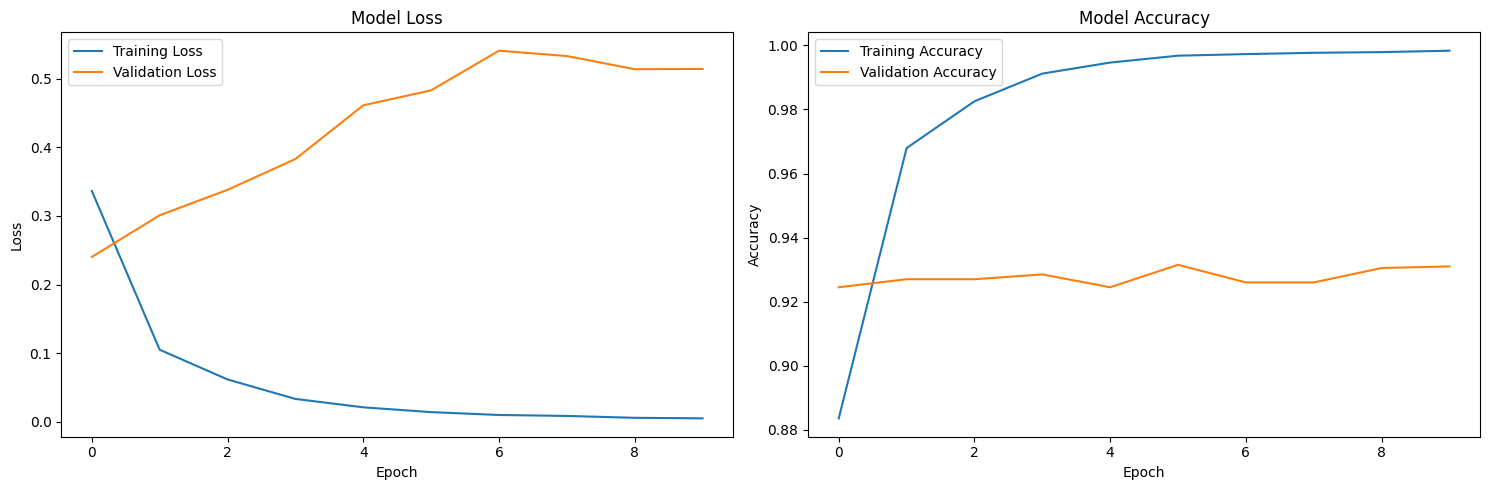

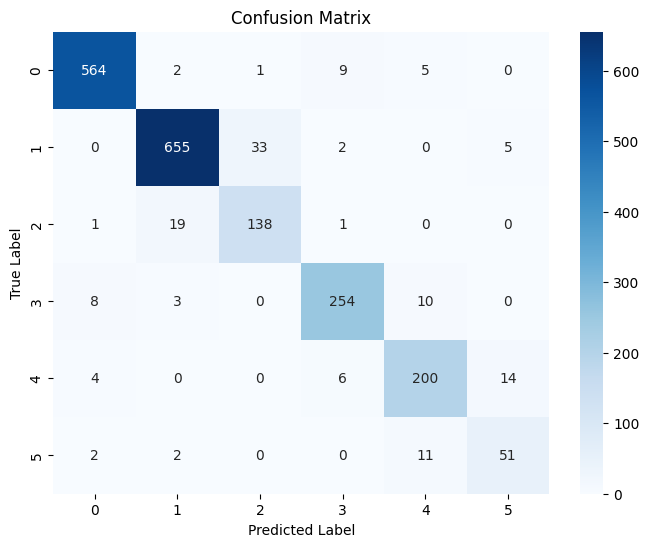


Saving model...

EXAMPLE PREDICTIONS
Text: This movie was absolutely amazing! I loved every minute of it.
Predicted Class (Index): 2 (Confidence: 0.9096)
--------------------------------------------------
Text: Terrible movie, waste of time. Very disappointed.
Predicted Class (Index): 0 (Confidence: 0.9999)
--------------------------------------------------
Text: It was okay, not great but not bad either.
Predicted Class (Index): 1 (Confidence: 0.9623)
--------------------------------------------------
Text: Outstanding performance by the lead actor. Highly recommend!
Predicted Class (Index): 1 (Confidence: 0.9999)
--------------------------------------------------


In [ ]:
import torch
from datasets import Dataset
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import DataLoader

# Define preprocess_function (assuming it's needed here)
def preprocess_function(examples, tokenizer, config):
    """Tokenize the input texts"""
    return tokenizer(
        examples['text'],
        truncation=True,
        padding='max_length',
        max_length=config.MAX_LENGTH,
        return_tensors='pt'
    )

# Define EmotionClassifier class
class EmotionClassifier:
    def __init__(self, config):
        self.config = config
        self.tokenizer = BertTokenizer.from_pretrained(config.MODEL_NAME)
        self.model = BertForSequenceClassification.from_pretrained(
            config.MODEL_NAME,
            num_labels=config.NUM_LABELS
        )
        self.model.to(config.DEVICE)

    def prepare_data(self, train_dataset, test_dataset):
        """Prepare datasets for training"""
        # Tokenize datasets
        train_tokenized = train_dataset.map(
            lambda x: preprocess_function(x, self.tokenizer, self.config), # Pass config here
            batched=True
        )
        test_tokenized = test_dataset.map(
            lambda x: preprocess_function(x, self.tokenizer, self.config), # Pass config here
            batched=True
        )

        # Set format for PyTorch
        train_tokenized.set_format(
            type='torch',
            columns=['input_ids', 'attention_mask', 'label']
        )
        test_tokenized.set_format(
            type='torch',
            columns=['input_ids', 'attention_mask', 'label']
        )

        return train_tokenized, test_tokenized

    def setup_training(self, train_dataset):
        """Setup optimizer and scheduler"""
        # Optimizer
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=self.config.LEARNING_RATE,
            weight_decay=self.config.WEIGHT_DECAY
        )

        # Learning rate scheduler
        total_steps = len(train_dataset) * self.config.NUM_EPOCHS // self.config.BATCH_SIZE
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=self.config.WARMUP_STEPS,
            num_training_steps=total_steps
        )

        print(f"Total training steps: {total_steps}")

    def train_epoch(self, train_loader):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0

        progress_bar = tqdm(train_loader, desc="Training")

        for batch in progress_bar:
            # Move batch to device
            input_ids = batch['input_ids'].to(self.config.DEVICE)
            attention_mask = batch['attention_mask'].to(self.config.DEVICE)
            labels = batch['label'].to(self.config.DEVICE)

            # Forward pass
            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()

            # Calculate accuracy
            predictions = torch.argmax(logits, dim=-1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
            total_loss += loss.item()

            # Update progress bar
            progress_bar.set_postfix({
                'loss': loss.item(),
                'acc': correct_predictions / total_predictions
            })

        avg_loss = total_loss / len(train_loader)
        accuracy = correct_predictions / total_predictions

        return avg_loss, accuracy

    def evaluate(self, test_loader):
        """Evaluate the model"""
        self.model.eval()
        total_loss = 0
        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Evaluating"):
                input_ids = batch['input_ids'].to(self.config.DEVICE)
                attention_mask = batch['attention_mask'].to(self.config.DEVICE)
                labels = batch['label'].to(self.config.DEVICE)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                loss = outputs.loss
                logits = outputs.logits

                total_loss += loss.item()

                predictions = torch.argmax(logits, dim=-1)
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_loss = total_loss / len(test_loader)
        accuracy = accuracy_score(all_labels, all_predictions)

        return avg_loss, accuracy, all_predictions, all_labels

    def train(self, train_dataset, test_dataset):
        """Main training loop"""
        train_tokenized, test_tokenized = self.prepare_data(train_dataset, test_dataset)

        # Create data loaders
        train_loader = DataLoader(
            train_tokenized,
            batch_size=self.config.BATCH_SIZE,
            shuffle=True
        )
        test_loader = DataLoader(
            test_tokenized,
            batch_size=self.config.BATCH_SIZE,
            shuffle=False
        )

        self.setup_training(train_tokenized)

        # Training history
        history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }

        print("Starting training...")
        for epoch in range(self.config.NUM_EPOCHS):
            print(f"\nEpoch {epoch + 1}/{self.config.NUM_EPOCHS}")
            print("-" * 50)

            # Training
            train_loss, train_acc = self.train_epoch(train_loader)

            # Evaluation
            val_loss, val_acc, _, _ = self.evaluate(test_loader)

            # Store metrics
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)

            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        return history, test_loader

    def predict(self, text):
        """Make prediction on a single text"""
        self.model.eval()

        # Tokenize input
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.config.MAX_LENGTH,
            return_tensors='pt'
        )

        # Move to device
        inputs = {key: value.to(self.config.DEVICE) for key, value in inputs.items()}

        # Make prediction
        with torch.no_grad():
            outputs = self.model(**inputs)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
            confidence = torch.max(predictions, dim=-1)[0].item()
            predicted_class = torch.argmax(predictions, dim=-1).item()

        # Assuming sentiment prediction logic is adjusted for multi-class
        # For now, let's just return the predicted class index and confidence
        return predicted_class, confidence


def plot_training_history(history):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy plot
    ax2.plot(history['train_acc'], label='Training Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    # Assuming 6 classes for the emotion dataset
    class_names = [str(i) for i in range(6)]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


if __name__ == "__main__":
    # Define configuration variables
    MODEL_NAME   = "bert-base-uncased"   # change if needed
    TEXT_FIELD   = "text"                # name of the text column
    LABEL_FIELD  = "label"               # name of the label column
    MAX_LENGTH   = 256                   # max sequence length
    BALANCE_DATA = True                  # set False to skip balancing
    AUGMENT_MINORITY = False             # set True to augment minority class
    AUG_PER_SAMPLE = 1                   # augmented variants per example
    NUM_LABELS   = 6                     # Number of emotion classes
    BATCH_SIZE   = 16                    # Adjust based on GPU memory
    LEARNING_RATE = 2e-5                 # Learning rate for optimizer
    WEIGHT_DECAY = 0.01                  # Weight decay for optimizer
    WARMUP_STEPS = 0                     # Number of warmup steps for scheduler
    DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # Define a simple config class
    class Config:
        MODEL_NAME   = MODEL_NAME
        NUM_LABELS   = NUM_LABELS
        MAX_LENGTH   = MAX_LENGTH
        BATCH_SIZE   = BATCH_SIZE
        NUM_EPOCHS   = NUM_EPOCHS
        LEARNING_RATE = LEARNING_RATE
        WEIGHT_DECAY = WEIGHT_DECAY
        WARMUP_STEPS = WARMUP_STEPS
        DEVICE       = DEVICE


    config = Config()

    # Load data
    splits = {'train': 'split/train-00000-of-00001.parquet', 'validation': 'split/validation-00000-of-00001.parquet', 'test': 'split/test-00000-of-00001.parquet'}
    df_train = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["train"])
    df_test = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["test"])
    df_validation = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["validation"])


    # Balance training data if needed
    if BALANCE_DATA:
        ros = RandomOverSampler(random_state=42)
        # Ensure df_train is a pandas DataFrame and has the correct columns
        if not isinstance(df_train, pd.DataFrame):
             # Assuming ds from preprocess_example is available and is a Dataset
             df_train_balanced = ds.to_pandas()
        else:
             df_train_balanced = df_train.copy()

        X_res, y_res = ros.fit_resample(
            df_train_balanced[[TEXT_FIELD]], df_train_balanced[LABEL_FIELD]
        )
        balanced_df = pd.concat([X_res, y_res], axis=1)
        train_dataset = Dataset.from_pandas(balanced_df)
        print("Class distribution after balancing:")
        print(balanced_df[LABEL_FIELD].value_counts())
    else:
        # If not balancing, use the original df_train
        if not isinstance(df_train, pd.DataFrame):
             # Assuming ds from preprocess_example is available and is a Dataset
             train_dataset = ds # Use the preprocessed dataset if balancing is skipped
        else:
             train_dataset = Dataset.from_pandas(df_train)


    # Convert test and validation dataframes to datasets
    test_dataset = Dataset.from_pandas(df_test)
    validation_dataset = Dataset.from_pandas(df_validation)


    # Initialize model
    bert_model = EmotionClassifier(config)

    # Train model
    history, test_loader = bert_model.train(train_dataset, test_dataset)

    # Final evaluation
    print("\n" + "="*50)
    print("FINAL EVALUATION")
    print("="*50)

    val_loss, val_acc, predictions, labels = bert_model.evaluate(test_loader)
    print(f"Final Validation Accuracy: {val_acc:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(labels, predictions,
                              target_names=[str(i) for i in range(config.NUM_LABELS)])) # Use class names based on NUM_LABELS

    # Plot results
    plot_training_history(history)
    plot_confusion_matrix(labels, predictions)

    # Save model
    print("\nSaving model...")
    bert_model.model.save_pretrained('./emotion_bert_model') # Changed directory name
    bert_model.tokenizer.save_pretrained('./emotion_bert_model') # Changed directory name

    # Example predictions
    print("\n" + "="*50)
    print("EXAMPLE PREDICTIONS")
    print("="*50)

    test_texts = [
        "This movie was absolutely amazing! I loved every minute of it.",
        "Terrible movie, waste of time. Very disappointed.",
        "It was okay, not great but not bad either.",
        "Outstanding performance by the lead actor. Highly recommend!"
    ]

    for text in test_texts:
        predicted_class, confidence = bert_model.predict(text)
        # Assuming sentiment prediction logic is adjusted for multi-class
        # For now, let's just print the predicted class index and confidence
        print(f"Text: {text}")
        print(f"Predicted Class (Index): {predicted_class} (Confidence: {confidence:.4f})") # Updated output format
        print("-" * 50)

In [ ]:
from sklearn.metrics import classification_report
emotions = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "angry",
    4: "fear",
    5: "surprise"
}
test_texts = [
        "This movie was absolutely amazing! I loved every minute of it.",
        "Terrible movie, waste of time. Very disappointed.",
        "It was okay, not great but not bad either.",
        "Outstanding performance by the lead actor. Highly recommend!"
    ]

for text in test_texts:
    predicted_class, confidence = bert_model.predict(text)
    # Assuming sentiment prediction logic is adjusted for multi-class
    # For now, let's just print the predicted class index and confidence
    print(f"Text: {text}")
    print(f"Predicted Class (Index): {predicted_class} ({emotions[predicted_class]}) (Confidence: {confidence:.4f})") # Updated output format
    print("-" * 50)

Text: This movie was absolutely amazing! I loved every minute of it.
Predicted Class (Index): 2 (love) (Confidence: 0.9096)
--------------------------------------------------
Text: Terrible movie, waste of time. Very disappointed.
Predicted Class (Index): 0 (sadness) (Confidence: 0.9999)
--------------------------------------------------
Text: It was okay, not great but not bad either.
Predicted Class (Index): 1 (joy) (Confidence: 0.9623)
--------------------------------------------------
Text: Outstanding performance by the lead actor. Highly recommend!
Predicted Class (Index): 1 (joy) (Confidence: 0.9999)
--------------------------------------------------
